<a href="https://colab.research.google.com/github/AshHydroCoder/GRACE-Downscaler/blob/Branch1/Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 39.2 MB/s eta 0:00:00


In [12]:
import joblib
model_rf = joblib.load(f'/content/drive/My Drive/Thesis/RFM/RFM.pkl')

In [24]:
import rioxarray
import geopandas as gpd
nepal_shp = gpd.read_file('/content/drive/MyDrive/Thesis/AQUIFER/South of Outer Himalaya Aquifer.shp')
nepal_shp = nepal_shp.set_crs('epsg:4326')

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
df_pr = pd.read_csv(f'/content/drive/MyDrive/Thesis/RFM/Predictor/combined_csv.csv')

In [5]:
df_pr

,time,y,x,SM,Evap_tavg,Qs_tavg,RadT_tavg,elevation,precipitation
0,2003-01-01,24.45,77.45,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-01,24.55,77.45,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-01,24.65,77.45,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-01,24.75,77.45,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-01,24.85,77.45,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1116715,2020-12-01,28.65,88.35,NaN,NaN,NaN,NaN,NaN,NaN
1116716,2020-12-01,28.75,88.35,NaN,NaN,NaN,NaN,NaN,NaN
1116717,2020-12-01,28.85,88.35,NaN,NaN,NaN,NaN,NaN,NaN
1116718,2020-12-01,28.95,88.35,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
exclude = ['time', 'x', 'y']
normalize = df_pr.columns.difference(exclude)
# Normalize only the selected columns
scaler = MinMaxScaler()
df_pr_normalized = scaler.fit_transform(df_pr[normalize])

# Create a new DataFrame with normalized data and reattach the excluded columns
df_pr_normalized = pd.DataFrame(df_pr_normalized, columns=normalize)
df_X = pd.concat([df_pr[exclude], df_pr_normalized], axis=1)

df_X = df_X.dropna()
#X =df_X.drop(['y','x','time'], axis=1)
order = ['Evap_tavg', 'Qs_tavg', 'RadT_tavg', 'SM', 'elevation', 'precipitation']
#order = ['Evap_tavg', 'aspect','elevation','slope', 'SoilMoi00_10cm_tavg', 'SoilMoi100_200cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg','NDVI', 'precipitation','Qs_tavg','SWE_inst']
X = df_X[order]
X

,Evap_tavg,Qs_tavg,RadT_tavg,SM,elevation,precipitation
18,0.017117,2.330307e-07,0.256410,0.091740,0.123313,0.012263
65,0.018860,1.355950e-07,0.259938,0.093216,0.096933,0.012263
66,0.022632,1.499482e-07,0.249358,0.094161,0.100613,0.010591
112,0.023157,1.194558e-06,0.256433,0.094477,0.099387,0.013378
113,0.026475,1.145897e-06,0.246304,0.095590,0.098773,0.012821
...,...,...,...,...,...,...
1116649,0.169705,4.216212e-08,0.326048,0.673701,0.103681,0.002230
1116650,0.132263,7.028613e-08,0.240375,0.600676,0.501840,0.002230
1116696,0.189286,1.186458e-07,0.313472,0.503685,0.075460,0.002230
1116697,0.209134,1.449977e-07,0.241387,0.508483,0.263190,0.002230


In [13]:
y_predicted = model_rf.predict(X)


In [15]:
df_X['lwe_thickness_predict'] = y_predicted
df_X
df_X.to_csv(f'/content/drive/MyDrive/Thesis/RESULT/DOWNSCALED/DS.csv', index=False)

# Export to nc file

In [16]:
import xarray as xr
import pandas as pd

# Convert dataframe to xarray Dataset
ds = xr.Dataset.from_dataframe(df_X.set_index(['time', 'y', 'x']))

# Export to NetCDF
ds.to_netcdf(f'/content/drive/MyDrive/Thesis/RESULT/DOWNSCALED/GRACE_0.1.nc')


# Visualize predicted model

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
GR = xr.open_dataset('/content/drive/MyDrive/Thesis/RAW/GRACE_Aquifer.nc')
#GR = GR.drop_vars('time_bounds')
GR = GR.rio.write_crs('epsg:4326')
GR = GR.rename({'lon':'x','lat':'y'})
GR = GR.rio.clip(nepal_shp.geometry,all_touched=True)
GR = GR.sel(time=slice('2003-01-01','2020-12-31'))

<ipython-input-30-59d9f447f46c>:18: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(mean_df.index, trendline, linestyle='--', color='g', label=f"Sen's Slope (Slope: {sen_slope:.4f})")


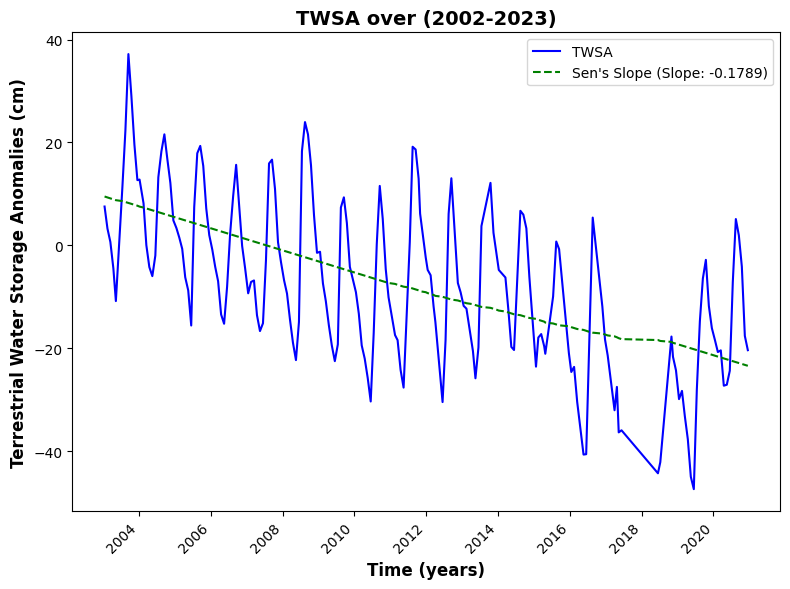

Sen's Slope: -0.1789
95% Confidence Interval: (-0.2177, -0.1412)


In [30]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
mean = GR.mean(dim = ['y','x'])
mean_df = mean.to_dataframe()
x = np.arange(len(mean_df))
y = mean_df['lwe_thickness'].values

# Calculate Sen's slope using Theil-Sen estimator
sen_slope, intercept, lower_slope, upper_slope = stats.theilslopes(y, x)

# Plot the original data
fig, ax = plt.subplots(figsize=(8, 6))
mean_df['lwe_thickness'].plot(ax=ax, marker='', linestyle='-', color='b', label='TWSA')

# Plot Sen's slope trendline
trendline = sen_slope * x + intercept
ax.plot(mean_df.index, trendline, linestyle='--', color='g', label=f"Sen's Slope (Slope: {sen_slope:.4f})")

# Customize the plot
ax.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Terrestrial Water Storage Anomalies (cm)', fontsize=12, fontweight='bold')
ax.set_title(f"TWSA over (2002-2023)", fontsize=14, fontweight='bold')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Print Sen's slope and confidence interval
print(f"Sen's Slope: {sen_slope:.4f}")
print(f"95% Confidence Interval: ({lower_slope:.4f}, {upper_slope:.4f})")

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
GR_DS = xr.open_dataset('/content/drive/MyDrive/Thesis/RESULT/DOWNSCALED/GRACE_0.1.nc')
GR_DS = GR_DS.rio.write_crs('epsg:4326')
GR_DS

<xarray.Dataset> Size: 63MB
Dimensions:                (time: 216, y: 47, x: 110)
Coordinates:
  * time                   (time) object 2kB '2003-01-01' ... '2020-12-01'
  * x                      (x) float64 880B 77.45 77.55 77.65 ... 88.25 88.35
  * y                      (y) float64 376B 24.45 24.55 24.65 ... 28.95 29.05
    spatial_ref            int64 8B 0
Data variables:
    Evap_tavg              (time, y, x) float64 9MB ...
    Qs_tavg                (time, y, x) float64 9MB ...
    RadT_tavg              (time, y, x) float64 9MB ...
    SM                     (time, y, x) float64 9MB ...
    elevation              (time, y, x) float64 9MB ...
    precipitation          (time, y, x) float64 9MB ...
    lwe_thickness_predict  (time, y, x) float64 9MB ...

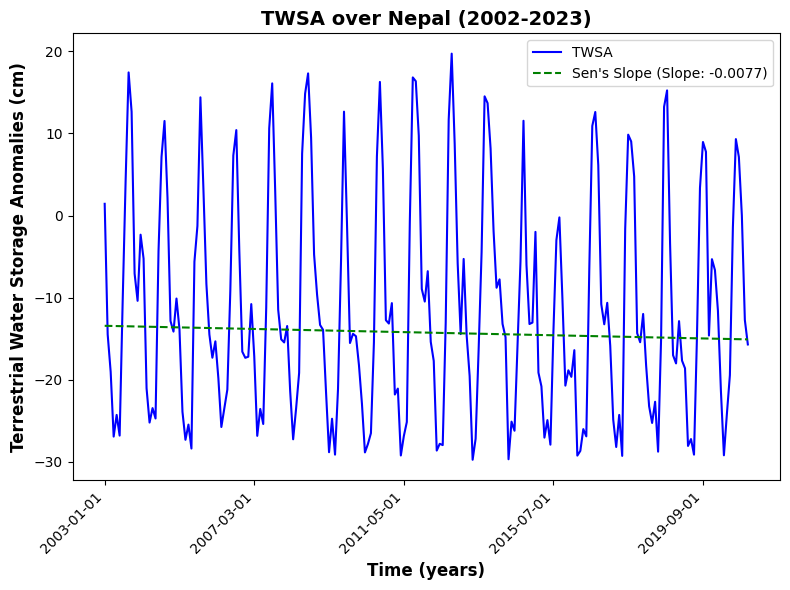

Sen's Slope: -0.0077
95% Confidence Interval: (-0.0324, 0.0180)


In [20]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
mean_ds = GR_DS.mean(dim = ['y','x'])
mean_ds_df = mean_ds.to_dataframe()
x = np.arange(len(mean_ds_df))
y = mean_ds_df['lwe_thickness_predict'].values

# Calculate Sen's slope using Theil-Sen estimator
sen_slope, intercept, lower_slope, upper_slope = stats.theilslopes(y, x)

# Plot the original data
fig, ax = plt.subplots(figsize=(8, 6))
mean_ds_df['lwe_thickness_predict'].plot(ax=ax, marker='', linestyle='-', color='b', label='TWSA')

# Plot Sen's slope trendline
trendline = sen_slope * x + intercept
ax.plot(mean_ds_df.index, trendline, linestyle='--', color='g', label=f"Sen's Slope (Slope: {sen_slope:.4f})")

# Customize the plot
ax.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Terrestrial Water Storage Anomalies (cm)', fontsize=12, fontweight='bold')
ax.set_title("TWSA over Nepal (2002-2023)", fontsize=14, fontweight='bold')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Print Sen's slope and confidence interval
print(f"Sen's Slope: {sen_slope:.4f}")
print(f"95% Confidence Interval: ({lower_slope:.4f}, {upper_slope:.4f})")

ValueError: x and y must have the same length.

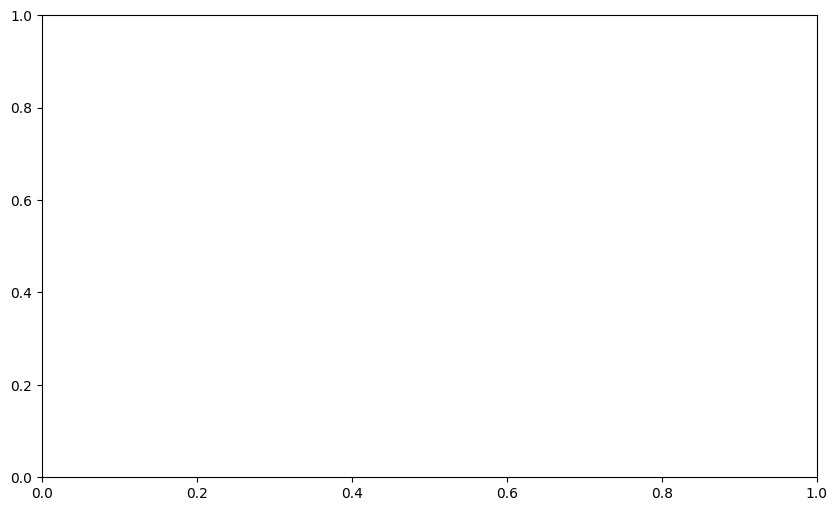

In [28]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate mean and convert to DataFrame for the first dataset
mean = GR.mean(dim=['y', 'x'])
mean_df = mean.to_dataframe()

x1 = np.arange(len(mean_df))
y1 = mean_df['lwe_thickness'].values

# Calculate Sen's slope for the first dataset
sen_slope1, intercept1, lower_slope1, upper_slope1 = stats.theilslopes(y1, x1)

# Calculate mean and convert to DataFrame for the second dataset
mean_ds = GR_DS.mean(dim=['y', 'x'])
mean_ds_df = mean_ds.to_dataframe()
x2 = np.arange(len(mean_ds_df))
y2 = mean_ds_df['lwe_thickness_predict'].values

# Calculate Sen's slope for the second dataset
sen_slope2, intercept2, lower_slope2, upper_slope2 = stats.theilslopes(y2, x2)

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate correlation between the two datasets
correlation, p_value = stats.pearsonr(y1, y2)
print(f"Pearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Convert the index to matplotlib-compatible format
# This line converts the DateTimeIndex to a list of strings
x_values = [str(date) for date in mean_ds_df.index]


# Plot the first dataset and its trendline
# Note: Using x1 here for the x-axis values
ax.plot(x1, y1, marker='', linestyle='-', color='b', label='TWSA - GR')
trendline1 = sen_slope1 * x1 + intercept1
ax.plot(x1, trendline1, linestyle='--', color='b', label=f"GR Sen's Slope (Slope: {sen_slope1:.4f})")

# Plot the second dataset and its trendline
# Note: Using x2 here for the x-axis values
ax.plot(x2, y2, marker='', linestyle='-', color='r', label='TWSA - GR_DS')
trendline2 = sen_slope2 * x2 + intercept2
ax.plot(x2, trendline2, linestyle='--', color='r', label=f"GR_DS Sen's Slope (Slope: {sen_slope2:.4f})")

# Customize the plot
ax.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Terrestrial Water Storage Anomalies (cm)', fontsize=12, fontweight='bold')
ax.set_title("TWSA over Cluster 5 (2003-2016)", fontsize=14, fontweight='bold')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Print Sen's slopes and confidence intervals
print("Dataset 1:")
print(f"Sen's Slope: {sen_slope1:.4f}")
print(f"95% Confidence Interval: ({lower_slope1:.4f}, {upper_slope1:.4f})")

print("\nDataset 2:")
print(f"Sen's Slope: {sen_slope2:.4f}")
print(f"95% Confidence Interval: ({lower_slope2:.4f}, {upper_slope2:.4f})")

In [33]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate mean and convert to DataFrame for the first dataset (GR)
mean = GR.mean(dim=['y', 'x'])
mean_df = mean.to_dataframe()

# Calculate mean and convert to DataFrame for the second dataset (GR_DS)
mean_ds = GR_DS.mean(dim=['y', 'x'])
mean_ds_df = mean_ds.to_dataframe()

# Find common dates in both datasets
common_index = mean_df.index.intersection(mean_ds_df.index)

# Subset both datasets to only keep common dates
mean_df = mean_df.loc[common_index]
mean_ds_df = mean_ds_df.loc[common_index]

# Extract time indices and values after filtering
x1 = np.arange(len(mean_df))
y1 = mean_df['lwe_thickness'].values

x2 = np.arange(len(mean_ds_df))
y2 = mean_ds_df['lwe_thickness_predict'].values

# Calculate Sen's slope for the first dataset
sen_slope1, intercept1, lower_slope1, upper_slope1 = stats.theilslopes(y1, x1)

# Calculate Sen's slope for the second dataset
sen_slope2, intercept2, lower_slope2, upper_slope2 = stats.theilslopes(y2, x2)

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate correlation between the two datasets
correlation, p_value = stats.pearsonr(y1, y2)
print(f"Pearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Convert the index to a matplotlib-compatible format
x_values = [str(date) for date in mean_ds_df.index]

# Plot the first dataset and its trendline
ax.plot(x1, y1, marker='', linestyle='-', color='b', label='TWSA - GR')
trendline1 = sen_slope1 * x1 + intercept1
ax.plot(x1, trendline1, linestyle='--', color='b', label=f"GR Sen's Slope (Slope: {sen_slope1:.4f})")

# Plot the second dataset and its trendline
ax.plot(x2, y2, marker='', linestyle='-', color='r', label='TWSA - GR_DS')
trendline2 = sen_slope2 * x2 + intercept2
ax.plot(x2, trendline2, linestyle='--', color='r', label=f"GR_DS Sen's Slope (Slope: {sen_slope2:.4f})")

# Customize the plot
ax.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Terrestrial Water Storage Anomalies (cm)', fontsize=12, fontweight='bold')
ax.set_title("TWSA over Cluster 5 (2003-2016)", fontsize=14, fontweight='bold')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Print Sen's slopes and confidence intervals
print("Dataset 1:")
print(f"Sen's Slope: {sen_slope1:.4f}")
print(f"95% Confidence Interval: ({lower_slope1:.4f}, {upper_slope1:.4f})")

print("\nDataset 2:")
print(f"Sen's Slope: {sen_slope2:.4f}")
print(f"95% Confidence Interval: ({lower_slope2:.4f}, {upper_slope2:.4f})")



<ipython-input-33-846ea36f7c24>:28: RuntimeWarning: All `x` coordinates are identical.
  sen_slope1, intercept1, lower_slope1, upper_slope1 = stats.theilslopes(y1, x1)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: iteration over a 0-d array

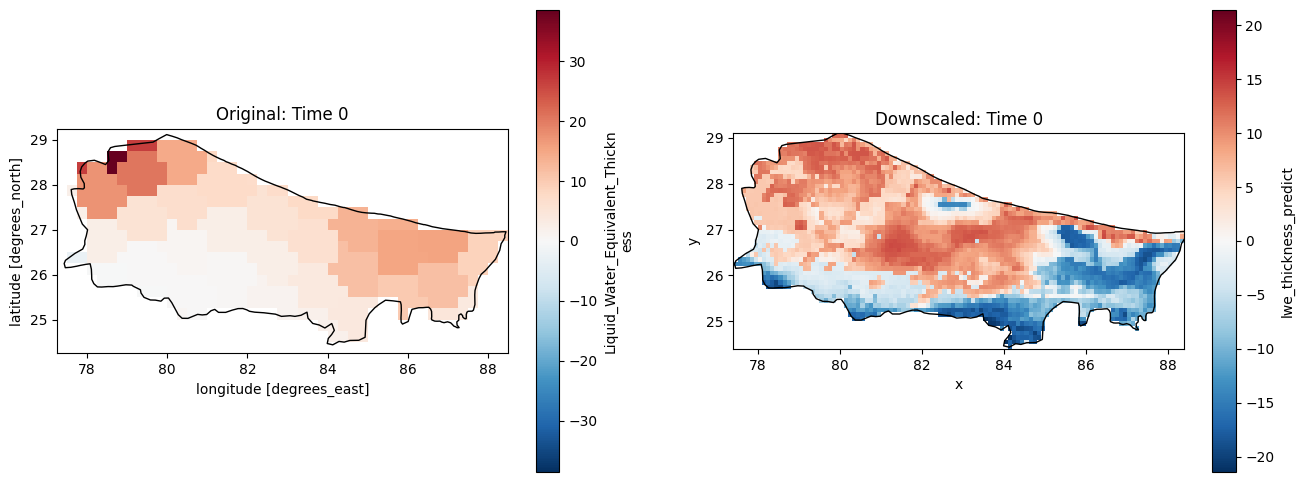

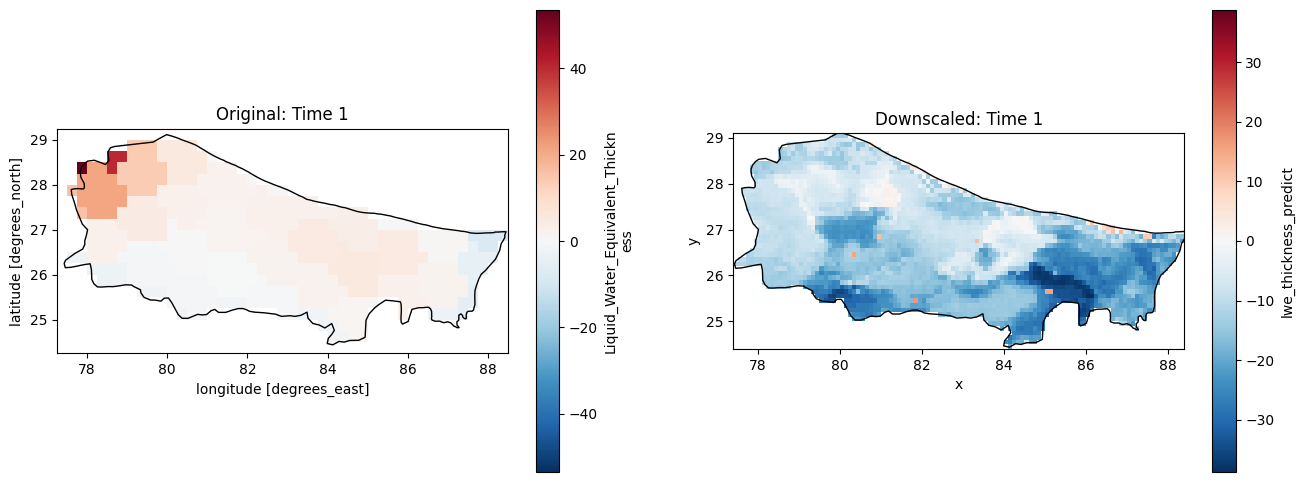

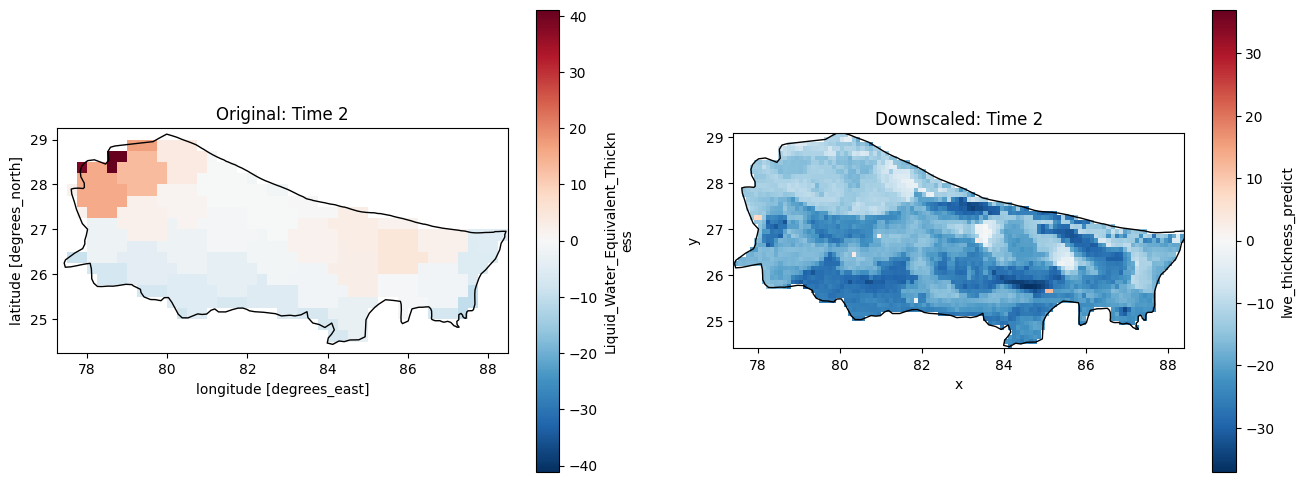

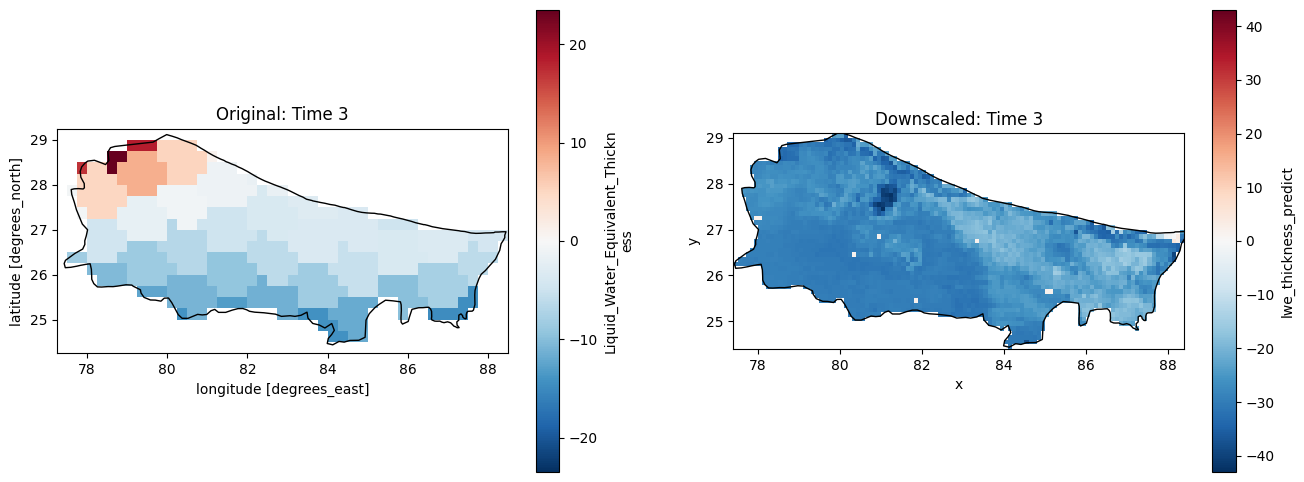

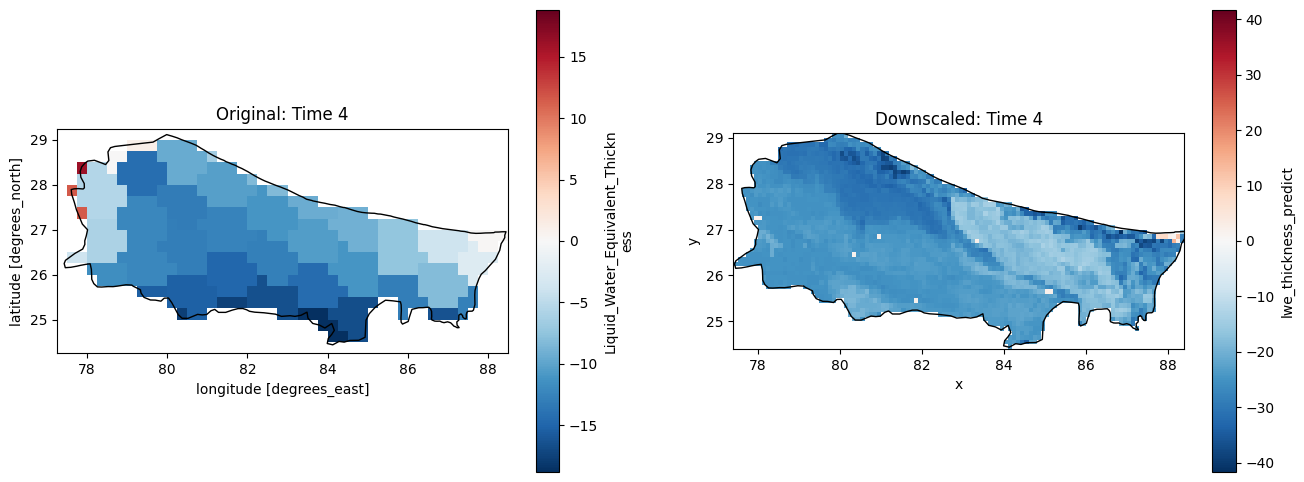

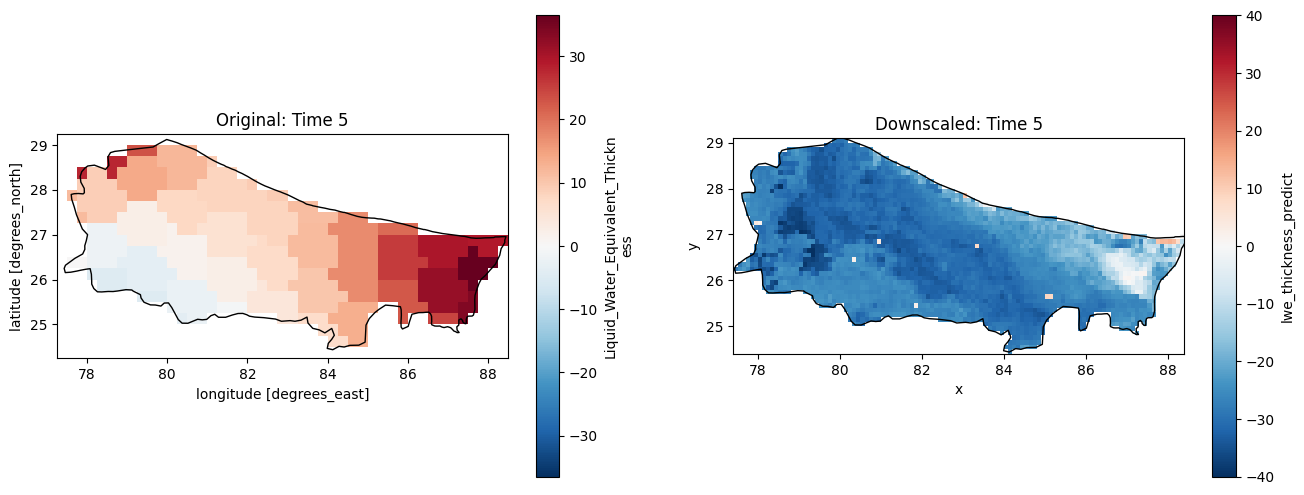

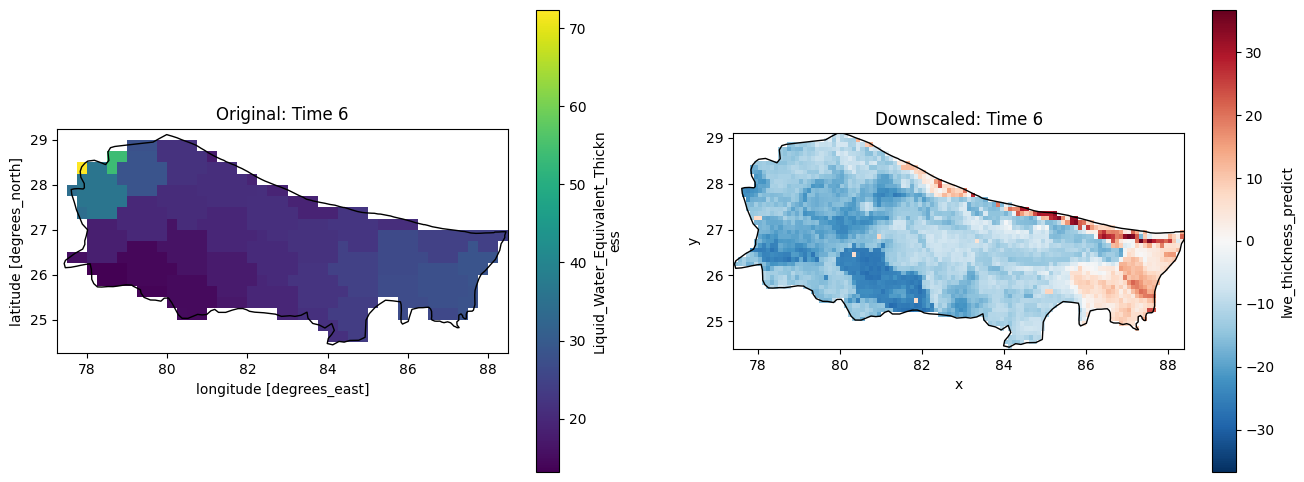

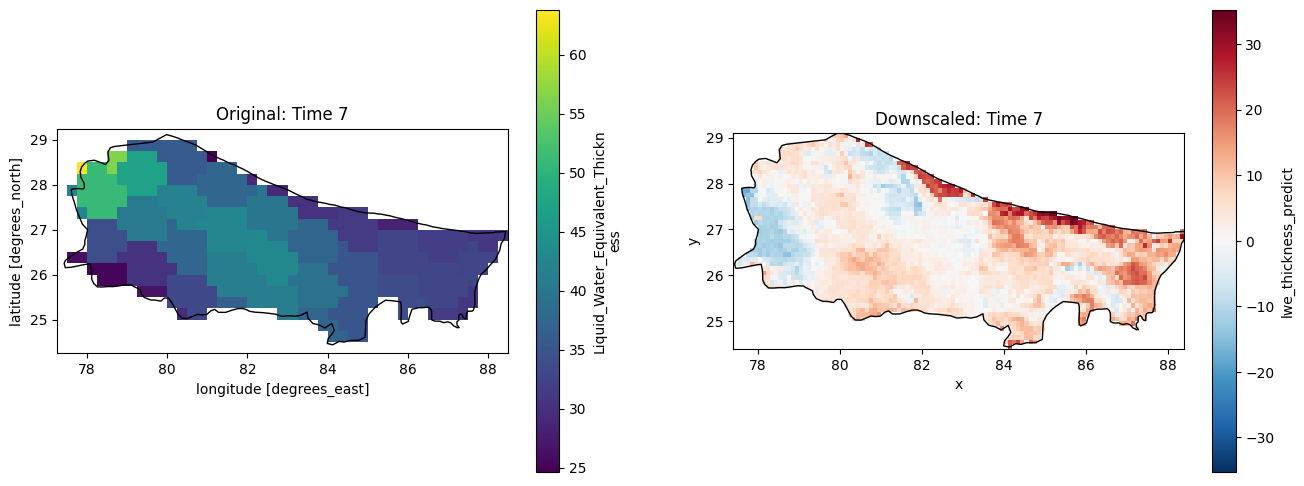

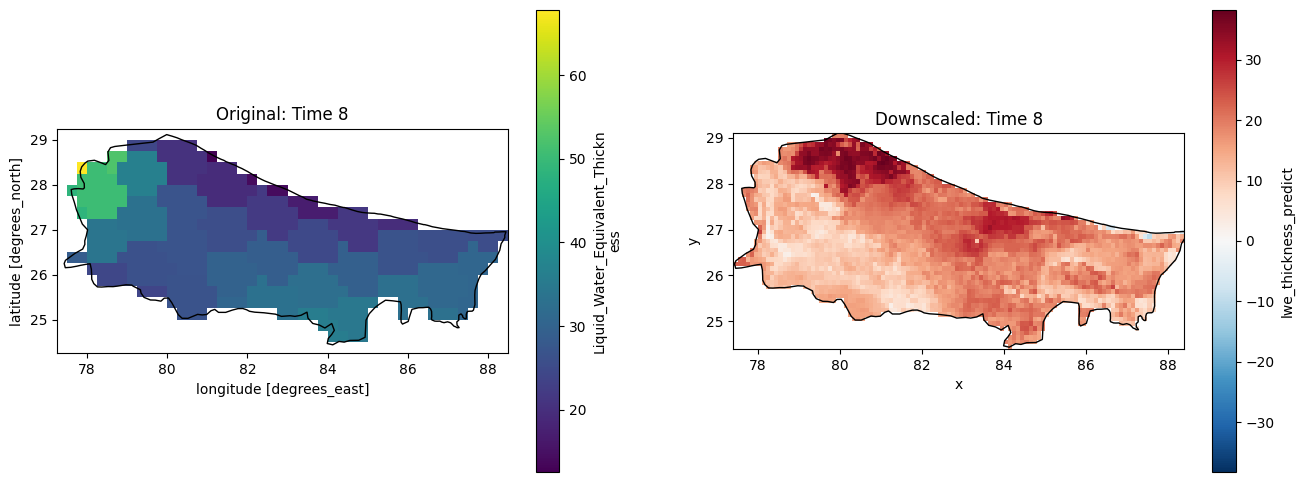

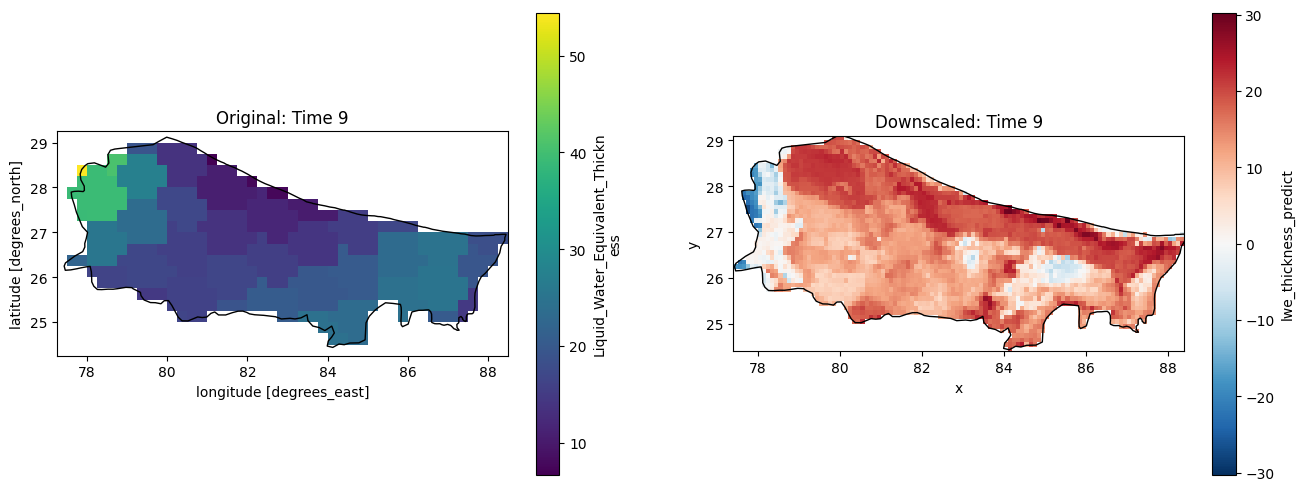

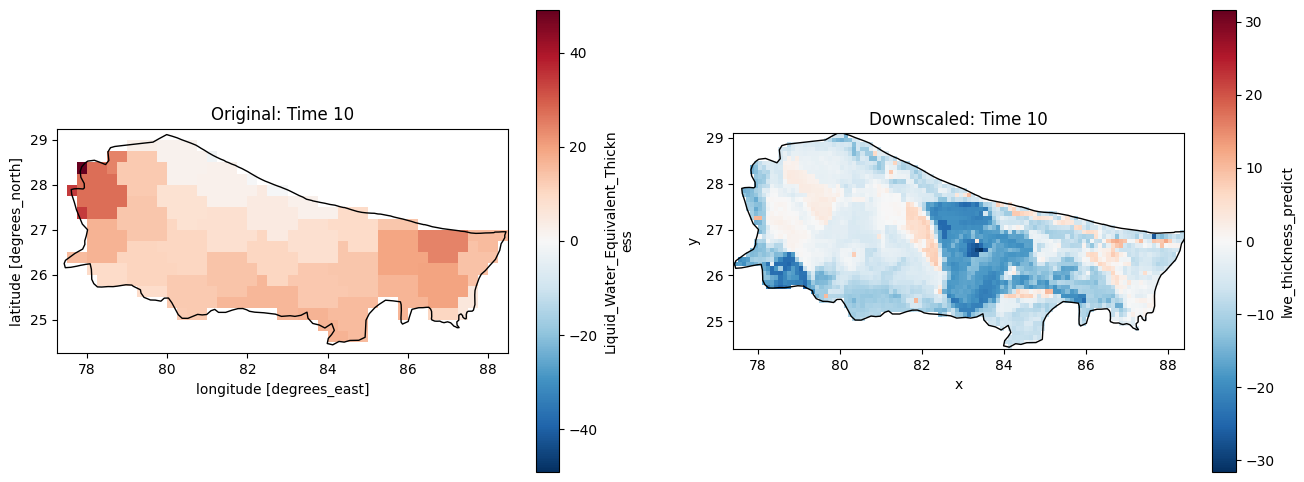

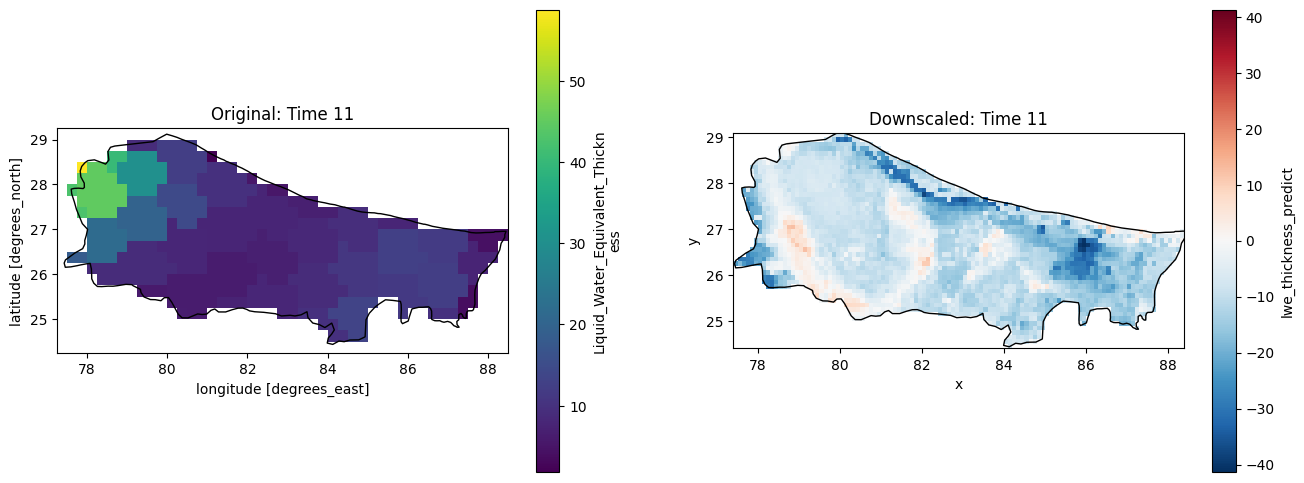

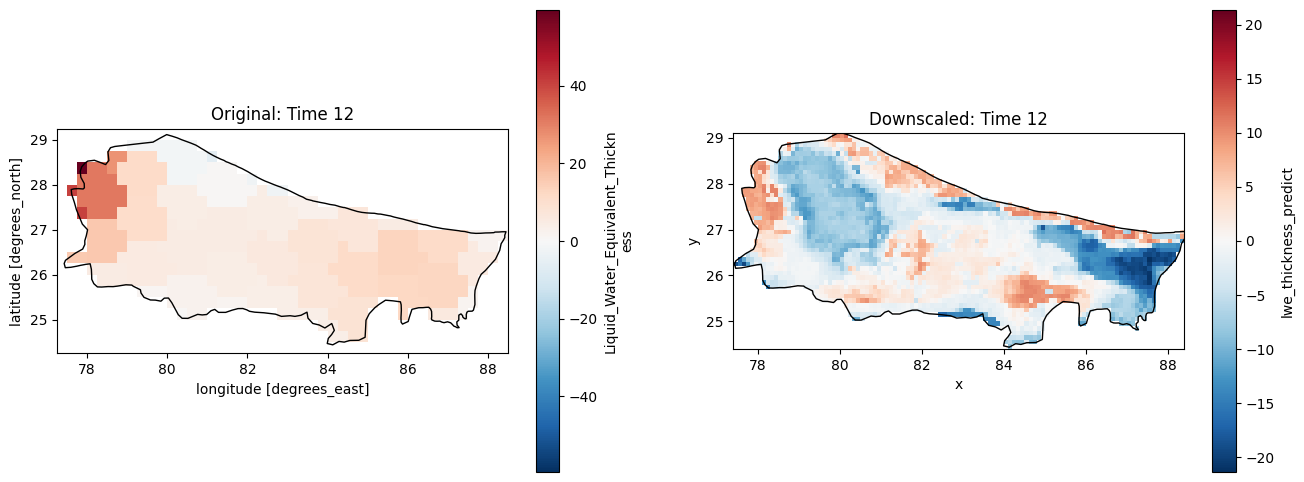

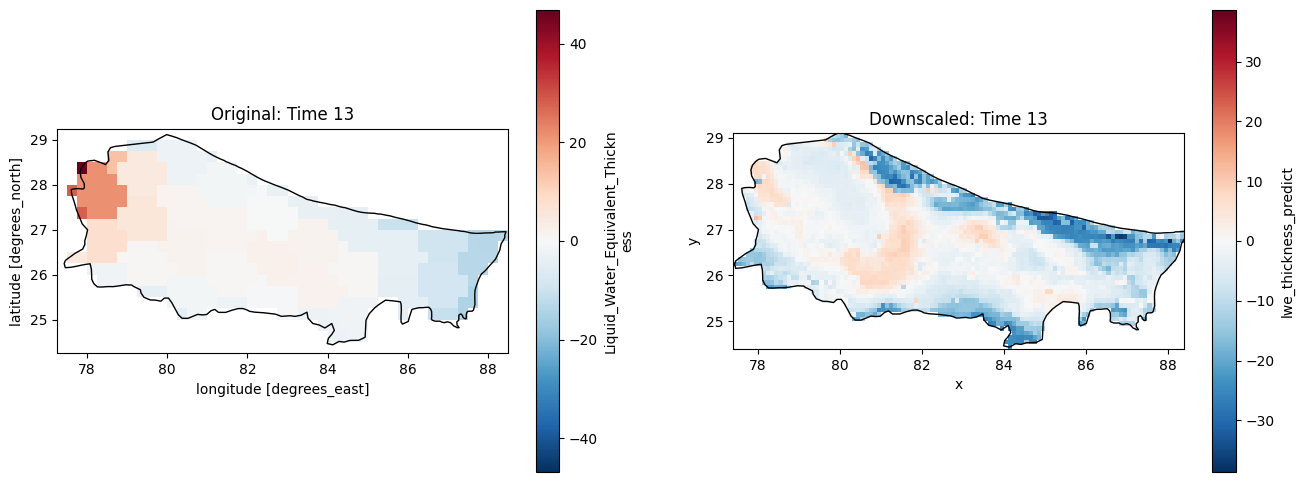

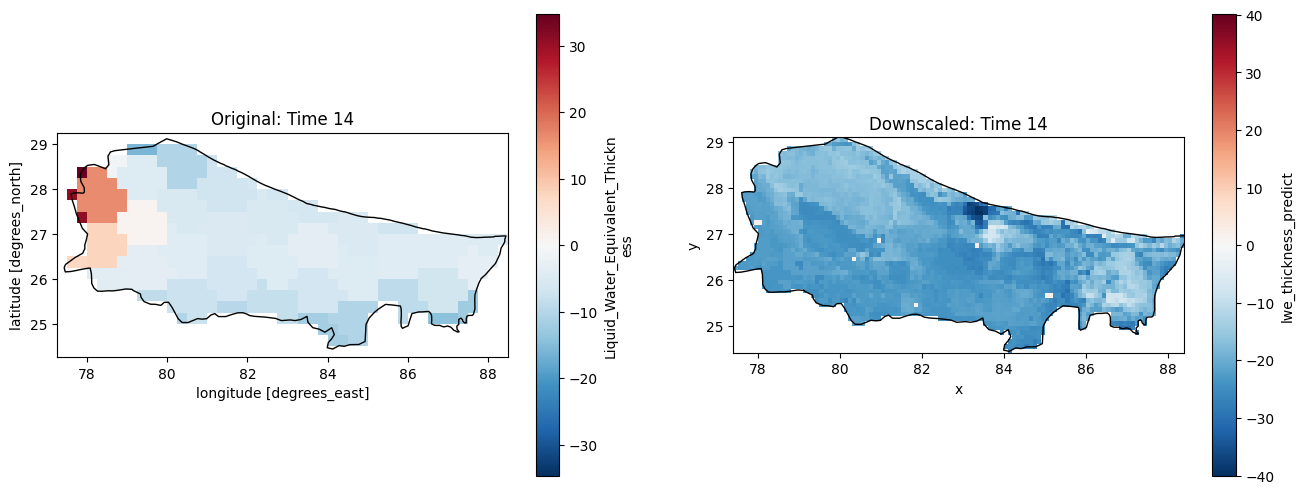

KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Function to plot original vs downscaled for a single time period
def plot_comparison(time_idx, original, downscaled, shape, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot original dataset
    original.isel(time=time_idx).plot(ax=axs[0])
    shape.plot(ax=axs[0], edgecolor='black', facecolor='None')
    axs[0].set_title(f'Original: Time {time_idx}')

    # Plot downscaled dataset
    downscaled.isel(time=time_idx).plot(ax=axs[1])
    shape.plot(ax=axs[1], edgecolor='black', facecolor='None')
    axs[1].set_title(f'Downscaled: Time {time_idx}')

    if title:
        plt.suptitle(title)
    plt.show()

# Loop through each time period to plot and compare datasets
for t in range(184):
    plot_comparison(t, GR.lwe_thickness, GR_DS.lwe_thickness_predict, nepal_shp)

# Function to plot a comparison for all months in a single year
def plot_year_comparison(year, original, downscaled, shape, time_index_map):
    # Assuming time_index_map is a dictionary that maps time index to a year-month pair
    times_in_year = [idx for idx, (yr, _) in time_index_map.items() if yr == year]

    n = len(times_in_year)
    fig, axs = plt.subplots(n, 2, figsize=(16, 6 * n))

    for i, t_idx in enumerate(times_in_year):
        # Plot original dataset
        original.isel(time=t_idx).plot(ax=axs[i, 0])
        shape.plot(ax=axs[i, 0], edgecolor='black', facecolor='None')
        axs[i, 0].set_title(f'Original: Time {t_idx}')

        # Plot downscaled dataset
        downscaled.isel(time=t_idx).plot(ax=axs[i, 1])
        shape.plot(ax=axs[i, 1], edgecolor='black', facecolor='None')
        axs[i, 1].set_title(f'Downscaled: Time {t_idx}')

    plt.suptitle(f'Comparison for Year {year}')
    plt.tight_layout()
    plt.show()

# Example usage for a specific year, assuming time_index_map is available
plot_year_comparison(2015, GR.lwe_thickness, GR_DS.lwe_thickness_predict, nepal_shp, time_index_map)

In [ ]:
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:00


AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: D

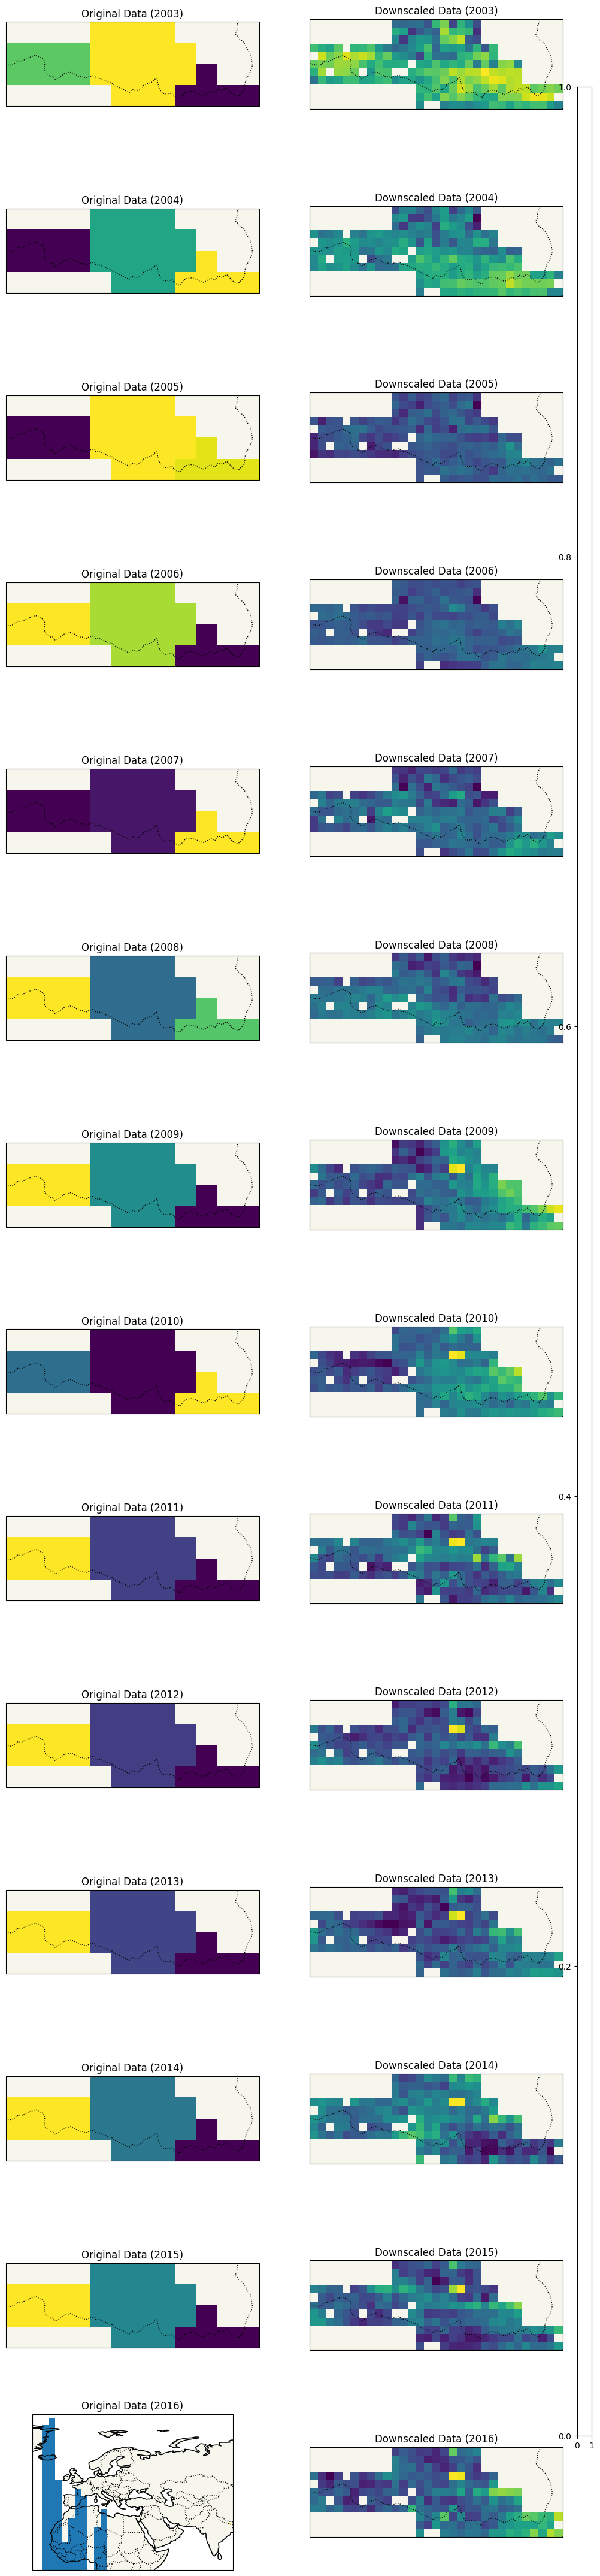

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Ensure 'time' is in datetime format for both datasets
GR['time'] = pd.to_datetime(GR['time'].values)
GR_DS['time'] = pd.to_datetime(GR_DS['time'].values)

# Calculate yearly averages for both datasets
GR_yearly = GR['lwe_thickness'].groupby(GR['time'].dt.year).mean('time')
GR_DS_yearly = GR_DS['lwe_thickness_predict'].groupby(GR_DS['time'].dt.year).mean('time')

# List of years common to both datasets
common_years = sorted(set(GR_yearly['year'].values) & set(GR_DS_yearly['year'].values))

# Plotting side-by-side comparison for each year
fig, axes = plt.subplots(
    len(common_years), 2,
    figsize=(12, 4 * len(common_years)),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for i, year in enumerate(common_years):
    # Original dataset plot
    ax1 = axes[i, 0] if len(common_years) > 1 else axes[0]
    GR_yearly.sel(year=year).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)
    ax1.set_title(f"Original Data ({year})")
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    ax1.add_feature(cfeature.LAND, edgecolor='black', alpha=0.5)

    # Downscaled dataset plot
    ax2 = axes[i, 1] if len(common_years) > 1 else axes[1]
    GR_DS_yearly.sel(year=year).plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)
    ax2.set_title(f"Downscaled Data ({year})")
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    ax2.add_feature(cfeature.LAND, edgecolor='black', alpha=0.5)

# Add a colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
GR_yearly.plot(ax=ax1, cmap='viridis', add_colorbar=True, cbar_ax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()
